# Prepare files

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from cmapPy.pandasGEXpress import parse
import os
from glob import glob

#params
sns.set_theme(font_scale=2.0)
pd.set_option('display.max_columns', 100)
N_WORKERS = 8 #number of process working in parallel during harmonization procedure

#create data storage folder for convenience
if not os.path.exists('data/'):
    os.makedirs('data/')

In [21]:
# unfortunately I don't have API key for using python API directly so let's download files manually
#download lvl5 perturbation data - this is a 33Gb file, so it would be nice if you already have it.
pert_path = '/tank/projects/kriukov_cmap/level5_beta_trt_cp_n720216x12328.gctx'   #<--- PLEASE, put your path to perturbation file here
if not os.path.exists(pert_path):
    os.system('wget -P data/  "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/level5/level5_beta_trt_cp_n720216x12328.gctx"')
    pert_path = './data/level5_beta_trt_cp_n720216x12328.gctx'

#download cmap genes if not
if not os.path.exists('data/geneinfo_beta.txt'):
    os.system('wget -P data/  "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/geneinfo_beta.txt"')
#download cmap compounds if not
if not os.path.exists('data/compoundinfo_beta.txt'):
    os.system('wget -P data/  "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/compoundinfo_beta.txt"')
#download signatures info if not
if not os.path.exists('data/siginfo_beta.txt'):
    os.system('wget -P data/  "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/siginfo_beta.txt"')

In [3]:
genes = pd.read_csv('./data/geneinfo_beta.txt', sep='\t', index_col=0)
comps = pd.read_csv('./data/compoundinfo_beta.txt', sep='\t', index_col=0)
signs = pd.read_csv('./data/siginfo_beta.txt', sep='\t', index_col='sig_id', low_memory=False)

In [22]:
#extract landmark genes and n compounds (due to time/memory economy) for the following analysis. 
n = 150 #number of top compounds - this number may decrease after filtering

lm = genes[genes.feature_space == 'landmark']
lm.index = lm.index.astype(str)
top_compounds_by_pert_count = signs.groupby('pert_id')['pert_id'].count().sort_values(ascending=False).index[:n].tolist()
cp = comps.loc[comps.index.intersection(top_compounds_by_pert_count)]
#filter signatures
sg = signs[signs.pert_id.isin(cp.index)]
sg = sg[sg.is_hiq == 1] #only high quality samples in the analysis
sg = sg.loc[sg[['pert_itime', 'pert_idose', 'cell_iname']].dropna(axis=0).index]
#preprocess features
sg['TIME'] = np.log2(sg.pert_itime.str.split(' ', expand=True)[0].astype(float))
sg['DOSE'] = np.log10(sg.pert_idose.str.split(' ', expand=True)[0].astype(float))

print("%d unique compounds left after filtration." % sg.pert_id.unique().shape[0])

141 unique compounds left after filtration.


In [23]:
# parse gene expression table (may take several minutes)
df = parse.parse(pert_path, rid=lm.index, cid=sg.index).data_df

# Data harmonization

## Model-intercept based approach

The idea of this approach is to extract the "pure" average effect of gene expression change for a particular gene followed by checking if most of the genes can demonstrate the effect. This can be done in the following several steps:

1. For each compound for each gene fit linear model to predict gene expression values of a particular signature from confounding variables: time, dose, cell type. We also fit intercept value for each gene.
2. Extract intercept values and corresponding p-values from models. Now these intercepts represent "average" gene expression change behavior under a particular compound. Some of these intercepts can be insignificant, but some are - we should check it.
3. Combine all p-values of intercepts for a particular compound into "average" p-value with [Stouffer](https://en.wikipedia.org/wiki/Fisher%27s_method#Relation_to_Stouffer.27s_Z-score_method) method.
4. Apply multiple testing correction (FDR BH) procedure to all combined p-values.
5. Filter those compounds that passes a level of significance, e.g. 0.05.

In [216]:
#data harmonization procedure
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from patsy import dmatrices
from scipy.stats import combine_pvalues
from tqdm import tqdm
from multiprocessing import Pool

itable = pd.DataFrame(columns=lm.index, index=sg.pert_id.unique()) #table for appending intercept values gene expression
ptable = pd.DataFrame(columns=lm.index, index=sg.pert_id.unique()) #same for pvalue

def fit_expression_one_intercept(arg):
    """ fit GLM to predict gene expression data from confounders
        arg::tuple (compound_id, gene_EntrezID)
        return intercept value and corresponding p-value from t-statistics
    """
    c, g = arg #pert_id and gene EntrezID
    tmp = sg[sg.pert_id==c]
    factors = tmp[['TIME', 'DOSE', 'cell_iname']]
    c_data = df[tmp.index]
    y = c_data.loc[g]
    y.name = 'expression'
    design = pd.merge(y, factors, left_index=True, right_index=True)
    y, X = dmatrices('expression ~ TIME + DOSE + cell_iname', data=design, return_type='dataframe')
    mod = sm.OLS(y, X) 
    OLS_result = mod.fit()
    return OLS_result.params['Intercept'], OLS_result.pvalues['Intercept'] #extract intercept value and p-value 

pairs = [(c, g) for c in sg.pert_id.unique() for g in lm.index.tolist()]
#Parallel processing save some time
pool = Pool(N_WORKERS) 
pool_g_result = pool.map(fit_expression_one_intercept, pairs)

#fill tables
for (c, g), (i, p) in zip(pairs, pool_g_result):
    itable.loc[c, g] = i
    ptable.loc[c, g] = p

Despite the parallel call of the function `fit_expression_one_intercept`, this solution still remains the performance 
bottleneck of the whole analysis. The possible solution could lie in avoiding slow python `statsmodels` framework. 
It can be achieved by using R pipeline for DE analysis instead of python one, for instance with `limma` package.

In [410]:
#aggregate pvalues with stouffer z-score method and apply multiple testing correction to exclude ambiguous compounds
agg_pval = [combine_pvalues(ptable.iloc[i].tolist(), method='stouffer')[1] for i in range(ptable.shape[0])]
passed_compounds = multipletests(agg_pval, method='fdr_bh', alpha=0.05)[0]
itable_final = itable[passed_compounds].astype(float)

In [26]:
#just look at the resulting table
itable_final

#this is a harmonized dataset prepared for the following analysis

,16,23,25,30,39,47,102,128,142,154,178,207,211,226,230,291,310,323,329,332,348,351,355,387,392,427,466,481,501,533,572,581,595,596,622,637,642,644,652,664,665,670,672,695,701,727,780,808,813,823,...,66008,79006,79071,79073,79080,79090,79094,79143,79170,79174,79187,79600,79643,79716,79850,79902,79921,79947,79961,80204,80212,80347,80349,80746,80758,81533,81544,83743,84159,84617,84722,84890,85236,85377,89910,90861,91137,91949,93487,93594,94239,116832,124583,147179,148022,200081,200734,256364,375346,388650
BRD-K81418486,-2.826018,-2.286712,-1.897774,2.326226,3.427604,1.389320,-1.466952,1.933214,-1.445518,2.962661,0.152530,0.676004,3.348231,-1.130693,0.799979,-0.884427,2.028431,0.172169,-1.280543,2.571498,-1.023281,-1.277278,0.529914,-0.671366,-1.462606,0.172552,-5.691402,1.967457,-1.938340,0.616148,1.461728,-0.408238,-1.945393,-0.906010,1.945976,0.009508,-0.937761,1.642682,0.053226,2.756557,3.203604,-1.207799,0.154548,0.373477,-0.461731,2.146457,-0.733592,-1.314542,0.509501,0.220107,...,1.654984,-1.410185,0.370687,-2.277382,0.527886,0.051166,-0.919807,1.044615,0.482889,-0.535059,-2.864103,-0.802969,-0.781243,1.590519,-3.360797,2.670182,2.215131,1.949891,1.121354,-0.431700,0.575368,-2.754075,0.739030,-0.270858,-1.371452,-0.415644,-0.373814,-1.949298,2.387072,-1.585446,0.999660,-1.969954,-2.917911,-1.429166,-0.375177,-1.470592,-1.676747,-2.202519,-2.526113,0.944114,0.084508,0.231056,0.077383,1.536844,-0.877120,-2.581570,-0.830289,-1.150718,1.306732,-0.513815
BRD-K70511574,0.528681,-1.376530,1.039212,-0.633989,-0.007273,-0.732496,2.658849,1.841801,-0.600273,2.261157,4.514198,-0.789720,-1.617000,0.866458,-1.339625,-2.044019,-0.174264,-0.604880,-1.959977,3.465218,-1.687345,0.288491,-1.502277,0.585827,1.821556,-0.412370,-0.094464,1.764597,-2.250480,0.810503,-1.673687,-1.668335,1.083874,6.012153,0.491369,-0.507311,1.139858,-1.591031,-0.672203,1.705328,0.057536,-2.222632,0.299764,-0.658123,0.808798,1.164533,0.939310,2.417039,0.989681,-0.929345,...,-0.615974,-0.583560,0.301052,3.528115,-4.175644,-2.000412,0.406108,-3.161276,-0.377118,0.700975,-0.744559,-1.029649,0.013515,-0.966157,-1.226143,0.907356,0.352767,-1.594477,4.071783,0.071381,-0.111346,1.198422,-1.302053,0.096428,-0.431849,-1.489936,-1.506143,0.583145,1.134021,-4.336046,2.296414,0.808289,-0.291975,1.056243,-0.865874,0.987642,-2.272763,-0.342454,-0.930768,1.414948,0.185318,0.570590,-2.959966,0.414901,-1.222448,-0.023596,-0.510746,0.218824,1.703370,1.874451
BRD-K85606544,0.008463,-0.050852,0.436803,-0.452640,0.331578,1.307092,-0.271217,0.400423,0.483797,0.012366,-0.863065,-0.240174,0.300838,0.507097,-0.788769,0.469827,1.335936,0.242093,0.070978,3.183326,-0.297319,-0.846704,0.582494,0.945835,-1.015012,-1.006027,-0.891550,-0.395920,0.124243,0.123600,-1.085372,-0.788483,0.068773,0.052576,0.606368,0.261998,0.108175,-0.655347,-0.063490,-0.322644,-0.392399,-0.479268,1.501008,-0.087993,0.293588,-0.160896,-1.414866,-0.360542,1.174330,-1.033688,...,-0.374594,-1.485424,1.823030,-0.120452,-0.510795,-1.346889,1.688920,-0.153760,0.229654,0.096614,-1.138944,-0.445571,-0.280128,-0.791717,-0.002291,2.057563,0.133786,-0.461580,-0.372930,2.153121,-0.730598,-1.992849,0.478659,0.298582,-1.134550,-0.592913,-0.119338,-0.720563,-0.599157,2.165549,0.689945,-2.617064,-2.246044,-0.431057,0.276387,0.511752,0.225035,-0.981864,-0.650996,0.440287,1.025374,1.378846,-2.449732,-0.071675,-0.025231,-0.150983,-0.918367,-1.598553,0.090236,0.109776
BRD-K21680192,1.060822,-2.702418,-0.301852,0.308257,-0.152705,1.076980,1.536088,-2.755125,1.450404,1.174950,0.512637,1.132839,-4.409352,1.218407,0.278565,1.820588,-0.031118,-1.115150,-0.522513,3.267737,-0.106148,-1.463282,2.066370,1.335231,0.425678,-0.712998,1.485604,-0.172130,0.062366,-0.489754,-0.092415,0.084923,0.645833,3.068950,0.240493,-0.253273,1.481752,2.730077,0.283827,1.984756,0.860246,-0.660390,1.064013,0.705572,-1.190148,2.059974,0.614228,-1.035156,0.101566,-0.597226,...,0.647195,0.987521,3.287968,-0.635183,2.205706,-0.713473,-0.342366,-2.804299,-0.642886,1.239328

## Naive approach

We also try a naive approach to data harmonization just by averaging all signatures within a particular compound id. Who knows, may be the effect of correlation and expression is rather strong

In [27]:
#naive harmonization approach: just average all signatures with the same pert_id 
itable_naive = df.T.loc[sg.index].groupby(sg.pert_id).mean()
itable_naive.head()

rid,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,10099,10112,10123,10131,10146,10150,10153,10165,1017,10174,10180,1019,10190,102,10206,1021,1022,10221,10227,10237,10245,1026,1027,10270,10273,10276,10285,1029,10298,10318,10320,10329,10362,10398,10434,10450,10451,10489,10491,10493,...,9533,9552,958,960,9637,9641,965,9650,9653,9670,9686,9688,9690,9695,9697,9702,9703,9709,9710,9712,9738,976,9761,9797,9801,9805,9813,9817,983,9833,9842,9847,9851,9854,9868,9897,9903,991,9915,9917,9918,9924,9926,9928,993,994,9943,9961,998,9988
pert_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BRD-A03506276,0.733521,0.257584,0.988559,-2.175959,-0.088279,3.027979,-1.582712,2.492427,-0.142578,-0.702694,0.893564,0.548295,-0.276995,-0.297727,-1.678239,1.458823,-0.050163,-0.513239,-2.271089,0.817037,0.616608,-2.817214,-1.644699,1.473280,0.835267,0.226617,3.402205,-2.065326,0.158973,-0.245816,-0.210436,0.165297,0.838482,0.318465,-1.245410,-0.491678,1.927436,0.500058,2.026938,-0.086252,0.378349,-3.237978,1.549295,2.177570,-1.324324,0.389891,2.676970,2.520350,1.564912,0.338655,...,0.043676,3.075471,0.232426,-1.056146,-0.370761,-1.283637,-0.988814,-0.574394,0.506112,0.551436,-0.239045,-1.315982,-0.561164,0.089530,0.864128,2.148857,0.125974,0.720977,1.202443,0.516494,-0.957715,-0.295545,0.073151,-0.595613,-0.046614,-0.596458,2.875742,0.689936,-0.402652,-1.163917,0.755313,-1.097434,0.835735,-0.169378,1.989864,0.274426,-0.455045,-1.791460,0.212104,1.014467,1.741539,0.662336,-0.049904,-0.310331,-1.936879,-0.053761,-0.897174,0.296259,-0.839433,-0.633580
BRD-A11990600,0.055052,-0.061061,-0.178731,0.131478,-0.072984,-0.375272,-0.192718,-0.562467,-0.265115,-0.063881,0.035668,-0.279441,0.010827,-0.241826,0.280852,0.038721,0.265308,0.289399,0.114165,0.286274,-0.427325,0.101741,0.560329,-0.088826,-0.050918,0.480251,0.219886,-0.241395,0.257581,0.067115,0.159945,-0.143113,-0.286093,0.062775,-0.354326,-0.076225,0.231354,-0.246126,-0.255287,-0.066064,0.029130,0.250116,-0.540869,0.423976,0.541803,0.280579,-0.032513,-0.320199,-0.003728,-0.443180,...,0.031405,-0.369776,-0.018248,-0.208306,0.197696,0.248465,0.313988,0.246504,0.191618,-0.123234,-0.044446,0.205768,-0.138477,-0.236061,0.090135,-0.055186,0.055056,0.335306,-0.011018,0.259648,-0.091510,0.040245,-0.305013,-0.007629,0.063506,-0.242109,-0.380538,-0.267423,0.190713,0.285090,-0.256867,-0.604815,0.260271,-0.045109,0.144332,-0.286227,0.149826,-0.105991,-0.147395,0.106635,-0.218404,-0.912585,0.207496,-0.011529,0.194754,-0.617521,-0.269207,-0.307031,0.752287,-0.292679
BRD-A12230535,0.544504,0.176842,-0.057624,-1.383426,0.181507,-0.100021,-1.656420,0.494441,0.581849,-0.254519,-0.377097,-1.865110,0.264996,-0.162488,-0.640737,0.179419,-0.489425,-0.106432,-1.061550,-0.358638,0.204313,-0.567763,-0.053124,0.306236,0.002118,0.139918,0.121393,0.163684,0.471637,-0.047969,0.095388,3.144292,-0.695838,-0.078285,0.151274,-0.325327,-0.375390,0.140348,-0.378091,0.376689,0.168138,-0.093552,-0.552805,0.015785,-0.024576,-0.096979,0.249338,0.330553,0.243549,0.147694,...,0.078240,0.047414,-0.041765,0.229502,0.278274,0.439996,-0.063939,-0.105608,-0.046301,0.046872,0.275127,-0.678875,0.013678,0.572906,0.202807,-0.262332,0.005255,0.175339,-0.009443,0.293711,-0.058453,0.580624,0.106729,-0.244926,-0.020185,-0.030997,-0.026690,-0.107966,-2.021329,-1.079635,0.116433,-0.385213,0.310378,0.227706,-0.222913,0.236850,0.278483,-2.031761,-0.119393,-0.226298,-0.778036,-0.617784,0.052498,-1.690975,-1.059377,-1.553791,-0.190497,1.176482,0.184697,0.021558
BRD-A13084692,0.157730,-0.142919,-0.082196,0.029518,0.325242,-0.526500,-0.230496,0.721417,-0.099727,-0.492391,0.113095,-0.358181,-0.331821,0.605536,-0.357147,-0.299001,0.156444,-0.018930,-0.151650,0.001513,0.296083,0.067851,-0.562000,-0.012141,-0.102308,0.033098,-0.263355,0.326928,-0.068186,0.049885,0.046877,0.907657,-0.505486,0.045121,-0.087405,-0.062734,0.140589,-0.697407,0.036856,-0.397809,0.390527,0.250039,-0.525772,-0.247362,0.069504,0.1

# Similarity analysis

In [52]:
#here we get Tonimoto similarity matrix from smiles
from rdkit import Chem
from rdkit import DataStructs

smiles = comps.loc[itable_final.index, 'canonical_smiles'].unique().tolist()
mols = [Chem.MolFromSmiles(m) for m in smiles]
fps = [Chem.RDKFingerprint(x) for x in mols]

sim = pd.DataFrame(0, columns=itable_final.index, index=itable_final.index)
for i in range(len(sim)):
    for j in range(i, len(sim)):
        sim.iloc[i,j] = sim.iloc[j,i] = DataStructs.FingerprintSimilarity(fps[i], fps[j])

In [53]:
cor = itable_final.T.corr(method='pearson')

In [54]:
#get upper triangle values from the matrices
m = cor.shape[0]
ridx,cidx = np.triu_indices(m, 1)
ucor = cor.to_numpy()[ridx, cidx]
usim = sim.to_numpy()[ridx, cidx]

## Simple correlation test

Here we conduct a simple correlation test to check if there is a linear relatioship between similarity value and aggregated gene expression signature value. For this we use Pearson and Spearman correlation tests.

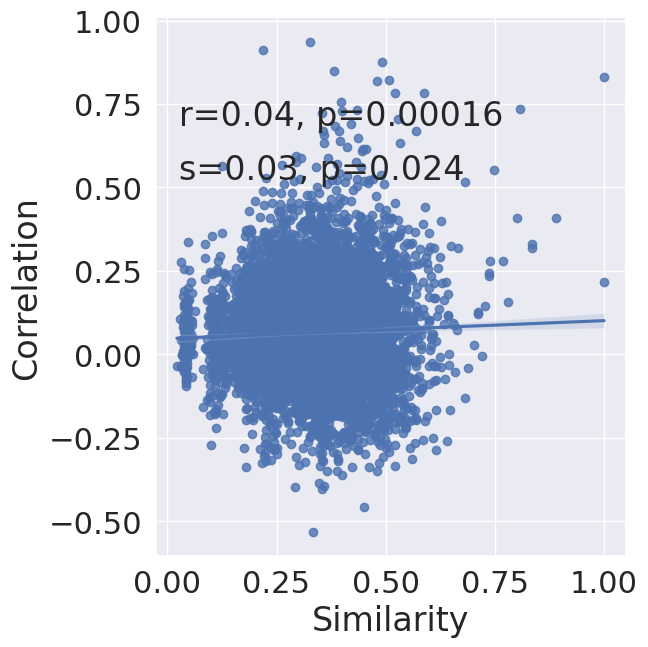

In [55]:
from scipy.stats import pearsonr, spearmanr

data = pd.DataFrame(dict(Similarity=usim, Correlation=ucor))
g = sns.lmplot(x="Similarity", y="Correlation", data=data, ci=95, height=7, aspect=1 );

def annotate(data, **kws):
    r, pr = pearsonr(data['Similarity'], data['Correlation'])
    s, ps = spearmanr(data['Similarity'], data['Correlation'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, pr),
            transform=ax.transAxes)
    ax.text(.05, .7, 's={:.2f}, p={:.2g}'.format(s, ps),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

It seems like not. I would not accept this a significant result.

## Two-sample KS test

The another approach is to split pairwise correlation values into two groups: low similarity and high similarity. Then, we just compare the destributions with KS test.

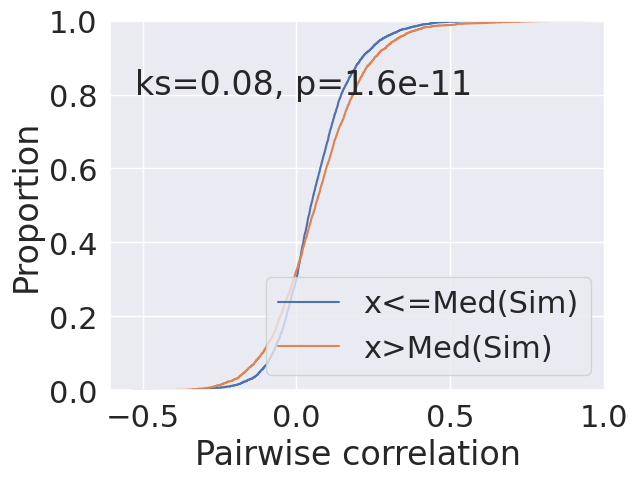

In [56]:
from scipy.stats import ks_2samp
#just split data by similarity median and test if the distrubutions are the same.
med = np.median(usim)
s1 = ucor[usim <= med]
s2 = ucor[usim > med]


def annotate(s1, s2):
    ks, p = ks_2samp(s1, s2)
    ax = plt.gca()
    ax.text(.05, .8, 'ks={:.2f}, p={:.2g}'.format(ks, p),
            transform=ax.transAxes)
    

sns.ecdfplot(s1, label='x<=Med(Sim)')
g = sns.ecdfplot(s2, label='x>Med(Sim)')
annotate(s1, s2)
plt.xlabel('Pairwise correlation')
plt.legend();

The distributions are different, but not dramatically. I tend to be skeptical about the "real" difference between these two distributions.

## Repeat for naive approach

In [57]:
from rdkit import Chem
from rdkit import DataStructs

smiles = comps.loc[itable_naive.index, 'canonical_smiles'].unique().tolist()
mols = [Chem.MolFromSmiles(m) for m in smiles]
fps = [Chem.RDKFingerprint(x) for x in mols]

sim = pd.DataFrame(0, columns=itable_naive.index, index=itable_naive.index)
for i in range(len(sim)):
    for j in range(i, len(sim)):
        sim.iloc[i,j] = sim.iloc[j,i] = DataStructs.FingerprintSimilarity(fps[i], fps[j])

In [58]:
cor = itable_naive.T.corr(method='pearson')

m = cor.shape[0]
ridx, cidx = np.triu_indices(m, 1)
ucor = cor.to_numpy()[ridx, cidx]
usim = sim.to_numpy()[ridx, cidx]

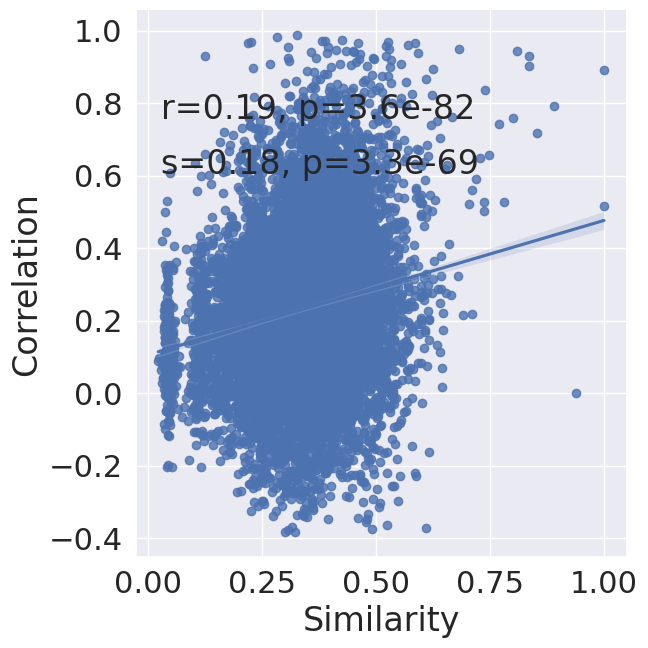

In [59]:
from scipy.stats import pearsonr, spearmanr

data = pd.DataFrame(dict(Similarity=usim, Correlation=ucor))
g = sns.lmplot(x="Similarity", y="Correlation", data=data, ci=95, height=7, aspect=1 );

def annotate(data, **kws):
    r, pr = pearsonr(data['Similarity'], data['Correlation'])
    s, ps = spearmanr(data['Similarity'], data['Correlation'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, pr),
            transform=ax.transAxes)
    ax.text(.05, .7, 's={:.2f}, p={:.2g}'.format(s, ps),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

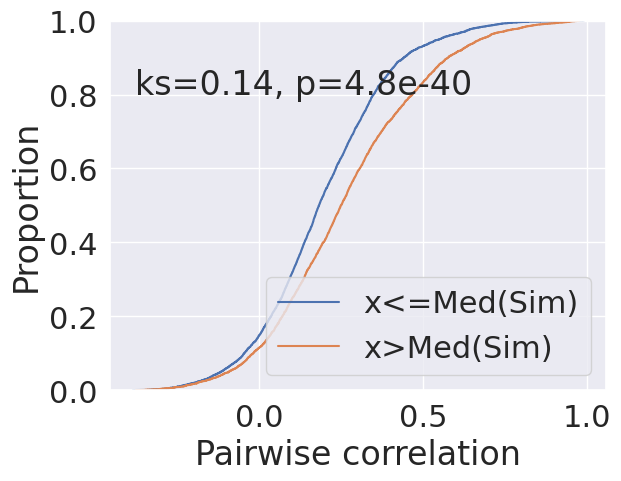

In [60]:
from scipy.stats import ks_2samp
#just split data by similarity median and test if the distrubutions are the same.
med = np.median(usim)
s1 = ucor[usim <= med]
s2 = ucor[usim > med]


def annotate(s1, s2):
    ks, p = ks_2samp(s1, s2)
    ax = plt.gca()
    ax.text(.05, .8, 'ks={:.2f}, p={:.2g}'.format(ks, p),
            transform=ax.transAxes)
    

sns.ecdfplot(s1, label='x<=Med(Sim)')
g = sns.ecdfplot(s2, label='x>Med(Sim)')
annotate(s1, s2)
plt.xlabel('Pairwise correlation')
plt.legend();

# Conclusion

From this analysis of 150 top (by number of conducted experiments) compounds I can conclude that there is no significant (in terms of strength of effect) positive correlation between Tonimoto similarity of small molecule compounds and corresponding correlation between gene expression changes. Possible caveats of the present analysis include:

* Rather small and biased selection of compounds from the CMAP dataset (based on the number of conducted assays).
* Selection of up to 1000 landmark genes whose linear combination (inferred) could introduce additional information about actual gene expression signatures behavior.
* Using Dosage and Time of treatment as continious factors within a harmonization procedure what is quite naive and done only for the sake of time economy.